In [ ]:
# Imports and helper functions
from typing import Dict, List, Tuple

import kornia.augmentation as K
import numpy as np
import torch
from capymoa.ann import resnet20_32x32
from capymoa.base import BatchClassifier
from capymoa.classifier import Finetune
from capymoa.ocl.base import TestTaskAware
from capymoa.ocl.datasets import SplitCIFAR10
from capymoa.ocl.evaluation import OCLMetrics, ocl_train_eval_loop
from capymoa.stream import Schema
from matplotlib import pyplot as plt
from torch import Tensor, nn
from torch.nn.functional import cross_entropy
from torch.utils.data import DataLoader, TensorDataset

from plot import plot_multiple

stream = SplitCIFAR10(normalize_features=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
schema = stream.schema
results: Dict[str, OCLMetrics] = {}


def run(learner: BatchClassifier) -> OCLMetrics:
    return ocl_train_eval_loop(
        learner,
        stream.train_loaders(128),
        stream.test_loaders(512),
        continual_evaluations=1,
        progress_bar=True,
        eval_window_size=256,
    )

# Replay

Replay continual learning methods store a buffer of past examples and sample from it
during training to mitigate catastrophic forgetting.

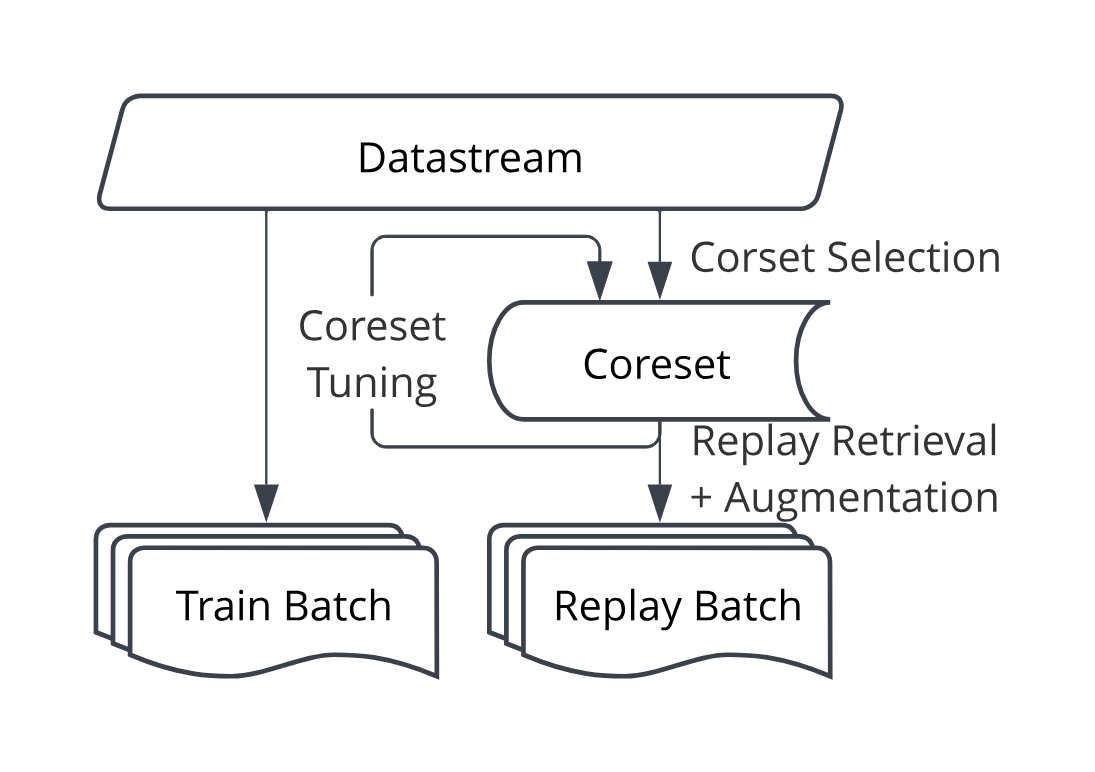

## Experience Replay

Experience replay is a baseline method that uses reservoir sampling to uniformly sample
from a buffer of past examples.

* **Coreset Selection**: Reservoir sampling is used to select a fixed-size buffer of
  past examples.
* **Coreset Retrieval**: During training, the learner samples uniformly from the buffer
  of past examples.
* **Coreset Exploitation**: The learner trains on the current batch of examples and the
  sampled buffer examples.


### Reservoir Sampling

Experience Replay uses [reservoir sampling](https://en.wikipedia.org/wiki/Reservoir_sampling)
to construct a simple random sample incrementally from a data stream of unknown
length. Here, we implement reservoir sampling "Algorithm R" [1].

---
1. Jeffrey S. Vitter. 1985. Random sampling with a reservoir. ACM Trans. Math.
   Softw. 11, 1 (March 1985), 37–57. https://doi.org/10.1145/3147.3165

In [ ]:
class ReservoirSampler:
    def __init__(
        self,
        item_count: int,
        feature_count: int,
        device: torch.device = torch.device("cpu"),
    ):
        self.item_count = item_count
        self.feature_count = feature_count
        self.reservoir_x = torch.zeros((item_count, feature_count)).to(device)
        self.reservoir_y = torch.zeros((item_count,), dtype=torch.long).to(device)
        self.count = 0

    def update(self, x: Tensor, y: Tensor) -> None:
        batch_size = x.shape[0]
        assert x.shape == (
            batch_size,
            self.feature_count,
        )
        assert y.shape == (batch_size,)

        for i in range(batch_size):
            if self.count < self.item_count:
                # Fill the reservoir
                self.reservoir_x[self.count] = x[i]
                self.reservoir_y[self.count] = y[i]
            else:
                # Reservoir sampling
                index = torch.randint(0, self.count + 1, (1,))
                if index < self.item_count:
                    self.reservoir_x[index] = x[i]
                    self.reservoir_y[index] = y[i]
            self.count += 1

    def sample_n(self, n: int) -> Tuple[Tensor, Tensor]:
        indices = torch.randint(0, min(self.count, self.item_count), (n,))
        return self.reservoir_x[indices], self.reservoir_y[indices]

Let's check to see if it's samples look uniform.

In [ ]:
x = torch.arange(0, 1_000).reshape(-1, 1).float()
y = torch.zeros(1_000, dtype=torch.long)
sampler = ReservoirSampler(500, 1)
sampler.update(x, y)
x = sampler.sample_n(200)
plt.hist(x[0].numpy(), bins=20)
plt.show()

In [ ]:
class ExperienceReplay(BatchClassifier):
    def __init__(
        self,
        schema: Schema,
        model: nn.Module,
        memory: int,
        lr: float,
        repeats: int = 1,
        device: torch.device = device,
    ):
        super().__init__(schema=schema)
        self.reservoir = ReservoirSampler(memory, schema.get_num_attributes(), device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.model = model.to(device)
        self.device = torch.device(device)
        self.repeats = repeats

    def batch_train(self, x: Tensor, y: Tensor):
        self.model.train()
        self.reservoir.update(x, y)

        # A common trick for online continual learning is todo multiple steps per batch.
        # The reservoir is sampled multiple times per batch to improve stability and avoid
        # overfitting.
        for _ in range(self.repeats):
            replay_x, replay_y = self.reservoir.sample_n(x.shape[0])
            train_x = torch.cat((x, replay_x), dim=0)
            train_y = torch.cat((y, replay_y), dim=0)

            self.optimizer.zero_grad()
            y_hat = self.model(train_x)
            loss = cross_entropy(y_hat, train_y)
            loss.backward()
            self.optimizer.step()

    @torch.no_grad
    def batch_predict_proba(self, x: Tensor) -> Tensor:
        return self.model.eval()(x.to(self.device))

In [ ]:
results["ER n=1_000"] = run(
    ExperienceReplay(schema, resnet20_32x32(10), memory=1_000, lr=0.001, repeats=5)
)
_ = plot_multiple(results, acc_seen=True, acc_online=True)


## Greedy sampler and a dumb learner (GDumb Baseline)

*   **Coreset Selection**: It greedily stores samples in a class-balanced buffer.
*   **Coreset Retrieval**: During training, the learner samples uniformly from the buffer
    of past examples.
*   **Coreset Exploitation**: Before inference, the learner is reset and trains solely
    on the stored samples.

Since online learners do not have an ``inference time," GDumb is an offline algorithm,
but GDumb remains a useful baseline. Essentially, GDumb downsamples the data set and
trains offline.

---
1.  Prabhu, A., Torr, P. H. S., & Dokania, P. K. (2020). **GDumb: A Simple Approach that
    Questions Our Progress in Continual Learning.** In A. Vedaldi, H. Bischof, T. Brox, &
    J.-M. Frahm (Eds.), Computer Vision – ECCV 2020 (pp. 524–540). Springer International
    Publishing. https://doi.org/10.1007/978-3-030-58536-5_31



In [ ]:
class GDumb(BatchClassifier, TestTaskAware):
    """
    GDumb: A Simple Approach for Online Class-Incremental Learning
    https://arxiv.org/abs/2005.12797
    """

    def __init__(
        self,
        schema: Schema,
        model: nn.Module,
        epochs: int,
        batch_size: int,
        memory: int,
        lr: float = 0.001,
        device: str | torch.device = device,
    ):
        super().__init__(schema)
        self.schema = schema
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.device = torch.device(device)
        self.model = model.to(device)
        self.original_state_dict = model.state_dict()
        self.buffer: Dict[int, List[Tensor]] = {
            k: [] for k in range(schema.get_num_classes())
        }
        self.coreset_size = memory
        self.loss_func = nn.CrossEntropyLoss()

    @property
    def count(self) -> int:
        return sum(self.class_counts)

    @property
    def class_counts(self) -> List[int]:
        return [len(v) for v in self.buffer.values()]

    def batch_train(self, x: Tensor, y: Tensor) -> None:
        for xi, yi in zip(x, y):
            yi = int(yi.item())

            # Room left in the coreset for this example
            if self.count < self.coreset_size:
                self.buffer[yi].append(xi.cpu())
            else:
                # Coreset is full, replace a random example from the majority class
                replace_class = int(np.argmax(self.class_counts))
                replace_idx = np.random.randint(len(self.buffer[replace_class]))
                del self.buffer[replace_class][replace_idx]
                self.buffer[yi].append(xi.cpu())

    def batch_predict_proba(self, x: Tensor) -> Tensor:
        return self.model(x).softmax(dim=1)

    def gdumb_fit(self) -> None:
        """
        Fit the model on the coreset.
        """
        # Assemble a dataset from the buffer
        x = torch.cat([torch.stack(v) for v in self.buffer.values() if len(v) > 0])
        y = torch.cat([torch.full((len(v),), k) for k, v in self.buffer.items()])
        dataset = TensorDataset(x, y)

        self.model.load_state_dict(self.original_state_dict)
        self.model.to(self.device)
        self.model.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            for batch_x, batch_y in loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.loss_func(outputs, batch_y)
                loss.backward()
                optimizer.step()

    def on_test_task(self, task_id: int) -> None:
        if task_id == 0:
            self.gdumb_fit()

In [ ]:
results["GDumb n=1_000"] = run(
    GDumb(schema, resnet20_32x32(10), epochs=500, batch_size=128, memory=1_000)
)
_ = plot_multiple(results, acc_seen=True)

## Repeated Augmented Rehearsal (RAR)

RAR is simple baseline that performs multiple optimization steps per-batch with
augmented rehearsal.

*   **Coreset Selection**: Reservoir sampling is used to select a fixed-size buffer of
    past examples.
*   **Coreset Retrieval**: During training, the learner samples uniformly from the buffer
    of past examples.
*   **Coreset Exploitation**: The learner trains on the current batch of examples and
    the sampled buffer examples, performing multiple optimization steps per-batch using
    random *augmentations* of the examples.

---
1.  Zhang, Yaqian, Bernhard Pfahringer, Eibe Frank, Albert Bifet, Nick Jin Sean Lim, and
    Yunzhe Jia. **“A Simple but Strong Baseline for Online Continual Learning: Repeated
    Augmented Rehearsal.”** In Advances in Neural Information Processing Systems 35:
    Annual Conference on Neural Information Processing Systems 2022, NeurIPS 2022, New
    Orleans, LA, USA, November 28 - December 9, 2022, edited by Sanmi Koyejo, S.
    Mohamed, A. Agarwal, Danielle Belgrave, K. Cho, and A. Oh, 2022.
    https://doi.org/10.5555/3600270.3601344.


In [ ]:
class RAR(BatchClassifier):
    """Repeated Augmented Rehearsal"""

    def __init__(
        self,
        learner: BatchClassifier,
        coreset_size: int,
        augment: nn.Module = nn.Identity(),
        seed: int = 0,
        repeats: int = 1,
        device: str | torch.device = device,
        shape: Tuple[int, int, int] = (3, 32, 32),
    ) -> None:
        super().__init__(learner.schema)
        num_features = learner.schema.get_num_attributes()
        self.device = torch.device(device)
        self.learner = learner
        self.augment = augment.to(self.device)
        self.repeats = repeats
        self.coreset = ReservoirSampler(coreset_size, num_features, self.device)
        self.shape = shape

    def train_step(self, x_fresh: Tensor, y_fresh: Tensor) -> None:
        # Sample from reservoir and augment the data
        n = x_fresh.shape[0]
        x_replay, y_replay = self.coreset.sample_n(n)
        x = torch.cat((x_fresh, x_replay), dim=0).to(self.device, self.x_dtype)
        y = torch.cat((y_fresh, y_replay), dim=0).to(self.device, self.y_dtype)
        x = x.view(-1, *self.shape)
        x: Tensor = self.augment(x)

        # Train the learner
        x = x.to(self.learner.device, self.learner.x_dtype)
        y = y.to(self.learner.device, self.learner.y_dtype)
        self.learner.batch_train(x, y)

    def batch_train(self, x: Tensor, y: Tensor) -> None:
        self.coreset.update(x, y)
        for i in range(self.repeats):
            self.train_step(x, y)

    @torch.no_grad()
    def batch_predict_proba(self, x: Tensor) -> Tensor:
        x = x.to(self.learner.device, self.learner.x_dtype)
        return self.learner.batch_predict_proba(x)

In [ ]:
# `kornia.augmentation`` applies the augmentation to each sample independently.
# This is useful since our augmentations are stochastic and we want to apply them
# multiple times to the same samples.
augment = K.AugmentationSequential(
    K.RandomHorizontalFlip(p=0.5, keepdim=True),
    K.RandomVerticalFlip(p=0.5, keepdim=True),
    K.RandomCrop(size=(32, 32), padding=4, padding_mode="reflect", keepdim=True),
)

model = resnet20_32x32(10)
learner = Finetune(schema, model, device=device)
results["RAR n=1_000"] = run(
    RAR(learner, coreset_size=1_000, augment=augment, repeats=5, device=device)
)
_ = plot_multiple(results, acc_seen=True, acc_online=True)